In [11]:
from google.colab import files
uploadImg = files.upload()

Saving mask.jpg to mask.jpg
Saving orange.jpg to orange.jpg


In [2]:
# install the libraries
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 19 09:08:16 2015
A Gaussian pyramid is basically a series of increasingly decimated images, 
traditionally at downsampling rate r=2. At each level, the image is first blurred by convolving with a Gaussian-like filter to prevent aliasing
in the downsampled image. We then move up a level in the Gaussian pyramid by downsampling the image (halving each dimension). 
To build the Laplacian pyramid, we take each level of the Gaussian pyramid and 
subtract from it the next level interpolated to the same size.

@author: bxiao from http://pauljxtan.com/blog/011315/

"""
# read three images
apple = imageio.imread("apple.jpg")
orange = imageio.imread("orange.jpg")
mask = imageio.imread("mask.jpg")

# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
#plt.imshow(kernel)
#plt.show()


#img_up = np.zeros((2*img.shape[0], 2*img.shape[1]))
#img_up[::2, ::2] = img
#ndimage.filters.convolve(img_up,4*kernel, mode='constant')

#sig.convolve2d(img_up, 4*kernel, 'same')

def interpolate(image):
    """
    Interpolates an image with "upsampling" rate r=2.
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    #return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates at image with "downsampling" rate r=2.
    """
    # Blur
    #image_blur = sig.convolve2d(image, kernel, 'same')
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                                 
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
        image  : the original image (i.e. base of the pyramid)
    Returns :
        G   : the Gaussian pyramid
        L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 2 and image.shape[1] >= 2:
        image = decimate(image) # downsample the signal
        G.append(image)
        
    # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L

print(apple, orange, mask)


#interpolate(img)
#decimate(img)
[G,L] = pyramids(apple)
plt.imshow(pyramids(apple))

# reconstruct the pyramids, here you write a reconstrut function that takes the 
# pyramid and upsampling the each level and add them up. 
"""
def reconstruct(L, G):

  

rows, cols = img.shape
composite_image = np.zeros((rows, cols + cols / 2), dtype=np.double)
composite_image[:rows, :cols] = G[0]

i_row = 0
for p in G[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows


fig, ax = plt.subplots()
    
ax.imshow(composite_image,cmap='gray')
plt.show()


rows, cols = img.shape
composite_image = np.zeros((rows, cols + cols / 2), dtype=np.double)

composite_image[:rows, :cols] = L[0]

i_row = 0
for p in L[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows


fig, ax = plt.subplots()
    
ax.imshow(composite_image,cmap='gray')
plt.show()                 """          

[[[122 126  91]
  [115 119  82]
  [120 125  85]
  ...
  [153 168 103]
  [154 169 104]
  [155 171 106]]

 [[118 122  87]
  [110 114  77]
  [113 118  78]
  ...
  [166 181 114]
  [167 182 115]
  [169 186 118]]

 [[113 117  80]
  [107 111  74]
  [111 116  76]
  ...
  [162 179 108]
  [163 180 109]
  [166 184 110]]

 ...

 [[116 157 113]
  [118 159 115]
  [120 163 120]
  ...
  [ 98 139 109]
  [ 98 141 111]
  [100 143 113]]

 [[111 150 106]
  [113 152 108]
  [112 153 111]
  ...
  [ 98 143 112]
  [ 98 143 112]
  [ 99 144 113]]

 [[120 157 114]
  [119 158 114]
  [117 158 116]
  ...
  [111 156 125]
  [107 154 122]
  [105 152 120]]] [[[137 174 105]
  [141 178 109]
  [143 180 110]
  ...
  [243 253 255]
  [243 251 254]
  [240 248 250]]

 [[128 165  96]
  [131 168  99]
  [134 171 101]
  ...
  [244 255 254]
  [242 252 251]
  [238 249 245]]

 [[135 172 105]
  [136 173 104]
  [139 176 106]
  ...
  [186 202 191]
  [185 201 188]
  [185 199 186]]

 ...

 [[117 108 103]
  [116 107 102]
  [113 104  99]
  ..

RuntimeError: ignored

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


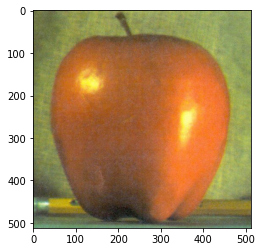

In [10]:
from google.colab import drive
drive.mount('/content/drive')
apple = imageio.imread("/content/drive/MyDrive/American_University/2021_Spring/CSC-676-001 Computer Vision/GitHub/Homeworks/hw3/homework3/pics/apple.jpg")
plt.imshow(apple)

# New Section

In [ ]:
# testing
import imageio
kernel = (1.0/256)*np.array([[1, 4,  6,  4,  1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4,  6,  4,  1]])

plt.imshow(kernel)
plt.show()
G = [img, ]
img = imageio.imread('apple.jpg')
# build the Gaussian Pyramid to maximum depth
while img.shape[0] >= 2 and img.shape[1] >= 2:
  img = decimate(img) # downsample the signal 
  G.append(img)

print(G)